# New York City Crime

<img src=images/banner.jpg/ width="600">

# Overview

# Business Understanding

New York City crime has gone through cycles. After the 2020 pandemic, many spoke about the increase in crime and the lack of enforcement against criminal behavior. The New York City Police Department (NYPD) is the largest and one of the oldest municipal police departments in the United States. The NYPD polices a city of approximately 8.5 million people. The purpose of this project is to **assist the NYPD keep crime levels low** through machine learning. I will do this **by creating a time series model to predict crime in New York City**. 

The stakeholders for this project include the New York City Police Commissioner and the Board of Commissioners. With an understanding of crime trends and future crime predictions, the executive staff can determine a future plan for officers to prevent future crime or stop future crime as soon as possible.

In this project, I will complete the following 3 tasks:
1. **Analyze** crime trends in historical New York City crime data.
2. Create a time series model to **predict** future crime in New York city.
3. **Evaluate** the time series model and recommend next steps for the New York City Police Department.

# Data Understanding

The [data](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data) has been extracted from NYC Open Data. It includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of 2023. There are 8,914,838 complaints reported. The data has 35 columns with reported information regarding each incident. The column descriptions can be found on the (data page)[https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data]. 



First I will import all the necessary libraries for EDA, data cleaning and modeling.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import random

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

random.seed(28)

In [2]:
# Import NYPD crime data and preview the first 5 rows to ensure it was imported correctly
data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')
data.head()

/var/folders/pn/v9tvzf9s5ms7zcp53821ct0m0000gn/T/ipykernel_38277/1856452097.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,25640826H10611,12/05/2006,10:38:00,NaN,(null),NaN,12/05/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO QUEENS NORTH,(null),25-44,WHITE HISPANIC,M
1,16631501H8965,08/25/1973,12:15:00,NaN,(null),NaN,05/29/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO MAN NORTH,(null),45-64,BLACK,F
2,11118212H8714,04/22/2006,16:50:00,NaN,(null),NaN,04/22/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),45-64,BLACK,M
3,23471265H9399,07/20/2006,22:37:00,NaN,(null),NaN,07/20/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,M
4,24565927H10142,04/14/2006,02:37:00,NaN,(null),NaN,04/14/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN NORTH,(null),45-64,BLACK,M


# Data Preparation

## Exploratory Data Analysis

In [3]:
# View the overall shape, dtypes and null counts for each column in train data
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914838 entries, 0 to 8914837
Data columns (total 35 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   CMPLNT_NUM         8914838 non-null  object 
 1   CMPLNT_FR_DT       8914183 non-null  object 
 2   CMPLNT_FR_TM       8914838 non-null  object 
 3   CMPLNT_TO_DT       7095880 non-null  object 
 4   CMPLNT_TO_TM       8914838 non-null  object 
 5   ADDR_PCT_CD        8914067 non-null  float64
 6   RPT_DT             8914838 non-null  object 
 7   KY_CD              8914838 non-null  int64  
 8   OFNS_DESC          8914838 non-null  object 
 9   PD_CD              8907245 non-null  float64
 10  PD_DESC            8914838 non-null  object 
 11  CRM_ATPT_CPTD_CD   8914838 non-null  object 
 12  LAW_CAT_CD         8914838 non-null  object 
 13  BORO_NM            8914838 non-null  object 
 14  LOC_OF_OCCUR_DESC  8914604 non-null  object 
 15  PREM_TYP_DESC      8914838 non-n

In [4]:
# Convert 'CMPLNT_NUM' to string
data['CMPLNT_NUM'] = data['CMPLNT_NUM'].astype(str)

In [5]:
# Check for duplicated using 'CMPLNT_NUM'
data['CMPLNT_NUM'].duplicated().value_counts()

CMPLNT_NUM
False    8913734
True        1104
Name: count, dtype: int64

In [6]:
data[data['CMPLNT_NUM'].duplicated() == True].sort_values('CMPLNT_NUM', axis=0)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
92052,10012321,01/03/2006,22:00:00,NaN,(null),62.0,01/03/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.614331,-73.979106,"(40.614331, -73.979106)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
337659,10012366,12/23/2005,10:30:00,NaN,(null),63.0,01/03/2006,109,GRAND LARCENY,415.0,...,(null),NaN,40.627544,-73.937954,"(40.627544, -73.937954)",PATROL BORO BKLYN SOUTH,(null),65+,BLACK,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239715,9966585,01/02/2005,16:30:00,NaN,(null),70.0,01/02/2006,109,GRAND LARCENY,421.0,...,(null),NaN,40.642402,-73.959552,"(40.642402, -73.959552)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,F
124876,9966658,01/04/2006,15:30:00,01/05/2006,09:30:00,72.0,01/05/2006,341,PETIT LARCENY,321.0,...,(null),NaN,40.661648,-73.981201,"(40.661648, -73.981201)",PATROL BORO BKLYN SOUTH,(null),45-64,WHITE,M
378931,9966757,12/15/2005,11:00:00,NaN,(null),75.0,01/03/2006,353,UNAUTHORIZED USE OF A VEHICLE,462.0,...,M,NaN,40.671360,-73.881811,"(40.6713598203364, -73.8818110231735)",PATROL BORO BKLYN NORTH,(null),18-24,BLACK,F
48564,9966791,01/04/2006,08:55:00,01/04/2006,09:00:00,76.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,(null),NaN,40.683651,-74.000304,"(40.6836512406856, -74.0003043120176)",PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,F


In [7]:
data[data['CMPLNT_NUM'].duplicated() == True].sort_values('CMPLNT_NUM').head(20)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
92052,10012321,01/03/2006,22:00:00,NaN,(null),62.0,01/03/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.614331,-73.979106,"(40.614331, -73.979106)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
337659,10012366,12/23/2005,10:30:00,NaN,(null),63.0,01/03/2006,109,GRAND LARCENY,415.0,...,(null),NaN,40.627544,-73.937954,"(40.627544, -73.937954)",PATROL BORO BKLYN SOUTH,(null),65+,BLACK,F
515607,10015119,01/05/2006,20:30:00,01/07/2006,02:00:00,45.0,01/07/2006,107,BURGLARY,224.0,...,(null),NaN,40.824741,-73.821517,"(40.824741, -73.821517)",PATROL BORO BRONX,(null),25-44,WHITE HISPANIC,F
358705,10015262,01/04/2006,16:48:00,01/04/2006,16:48:00,49.0,01/04/2006,236,DANGEROUS WEAPONS,782.0,...,(null),NaN,40.856577,-73.843894,"(40.8565767275976, -73.8438936779283)",PATROL BORO BRONX,(null),(null),UNKNOWN,E
467185,10015321,01/03/2006,18:00:00,01/03/2006,19:00:00,50.0,01/03/2006,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,M,NaN,40.882862,-73.903574,"(40.8828621313214, -73.9035744897024)",PATROL BORO BRONX,(null),65+,WHITE,F
489184,10015453,01/07/2006,21:46:00,01/07/2006,21:56:00,115.0,01/07/2006,113,FORGERY,723.0,...,(null),NaN,40.756568,-73.875932,"(40.7565675846374, -73.8759315341335)",PATROL BORO QUEENS NORTH,(null),(null),UNKNOWN,E
467859,10016512,01/04/2006,10:00:00,01/04/2006,23:00:00,113.0,01/05/2006,110,GRAND LARCENY OF MOTOR VEHICLE,441.0,...,(null),NaN,40.674323,-73.789208,"(40.674323, -73.789208)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,F


In [8]:
# View year range of data
## TO DO

In [9]:
data['LAW_CAT_CD'].value_counts().index[1]

'FELONY'

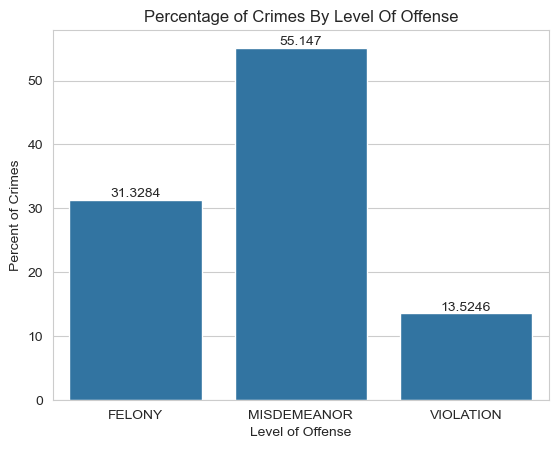

In [10]:
# Visualize crimes by level of offense
ax = sns.countplot(x="LAW_CAT_CD", data=data, stat='percent')
ax.set_xlabel('Level of Offense')
ax.set_ylabel('Percent of Crimes')
ax.set_title('Percentage of Crimes By Level Of Offense')
ax.bar_label(ax.containers[0]);

In [11]:
# View the different types of crime descriptions
data['OFNS_DESC'].value_counts()

OFNS_DESC
PETIT LARCENY                      1556946
HARRASSMENT 2                      1187346
ASSAULT 3 & RELATED OFFENSES        935330
CRIMINAL MISCHIEF & RELATED OF      876668
GRAND LARCENY                       783519
                                    ...   
FORTUNE TELLING                         13
ABORTION                                 7
OFFENSES AGAINST MARRIAGE UNCL           5
UNDER THE INFLUENCE OF DRUGS             3
KIDNAPPING AND RELATED OFFENSES          3
Name: count, Length: 73, dtype: int64

# INSERT SAMPLE DATA TO PLAY WITH

In [12]:
# Create a sample of the data to work with to decrease runtime
data_sample = data.sample(5000)
data_sample.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
7815550,235452939,10/23/2021,12:00:00,10/24/2021,14:30:00,111.0,10/25/2021,578,HARRASSMENT 2,638.0,...,M,NaN,40.737994,-73.759989,"(40.737994, -73.759989)",PATROL BORO QUEENS NORTH,(null),25-44,WHITE,M
6965640,211782047,04/06/2020,13:41:00,04/06/2020,15:26:00,120.0,04/06/2020,109,GRAND LARCENY,405.0,...,M,NaN,40.613717,-74.084818,"(40.613717, -74.084818)",PATROL BORO STATEN ISLAND,(null),UNKNOWN,UNKNOWN,D
8218283,249677710,08/16/2022,22:10:00,08/16/2022,22:17:00,50.0,08/16/2022,348,VEHICLE AND TRAFFIC LAWS,922.0,...,M,NaN,40.870258,-73.898354,"(40.870258, -73.898354)",PATROL BORO BRONX,(null),UNKNOWN,UNKNOWN,E
7264768,210060758,02/25/2020,12:10:00,02/25/2020,12:18:00,110.0,02/25/2020,106,FELONY ASSAULT,109.0,...,M,NaN,40.747682,-73.883467,"(40.747682, -73.883467)",PATROL BORO QUEENS NORTH,(null),18-24,WHITE HISPANIC,M
5511302,151301578,03/17/2016,12:30:00,03/17/2016,13:10:00,75.0,03/17/2016,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,F,NaN,40.679683,-73.866460,"(40.679683, -73.86646)",PATROL BORO BKLYN NORTH,(null),25-44,WHITE HISPANIC,M


In [13]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 7815550 to 8886354
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CMPLNT_NUM         5000 non-null   object 
 1   CMPLNT_FR_DT       5000 non-null   object 
 2   CMPLNT_FR_TM       5000 non-null   object 
 3   CMPLNT_TO_DT       3948 non-null   object 
 4   CMPLNT_TO_TM       5000 non-null   object 
 5   ADDR_PCT_CD        4999 non-null   float64
 6   RPT_DT             5000 non-null   object 
 7   KY_CD              5000 non-null   int64  
 8   OFNS_DESC          5000 non-null   object 
 9   PD_CD              4994 non-null   float64
 10  PD_DESC            5000 non-null   object 
 11  CRM_ATPT_CPTD_CD   5000 non-null   object 
 12  LAW_CAT_CD         5000 non-null   object 
 13  BORO_NM            5000 non-null   object 
 14  LOC_OF_OCCUR_DESC  5000 non-null   object 
 15  PREM_TYP_DESC      5000 non-null   object 
 16  JURIS_DESC         5

In [14]:
top_10_off_desc = data_sample.groupby('OFNS_DESC').size().sort_values(ascending=False).head(10)

In [15]:
top_10_off_desc

OFNS_DESC
PETIT LARCENY                     871
HARRASSMENT 2                     667
ASSAULT 3 & RELATED OFFENSES      558
CRIMINAL MISCHIEF & RELATED OF    488
GRAND LARCENY                     426
OFF. AGNST PUB ORD SENSBLTY &     257
DANGEROUS DRUGS                   255
FELONY ASSAULT                    213
BURGLARY                          164
ROBBERY                           158
dtype: int64

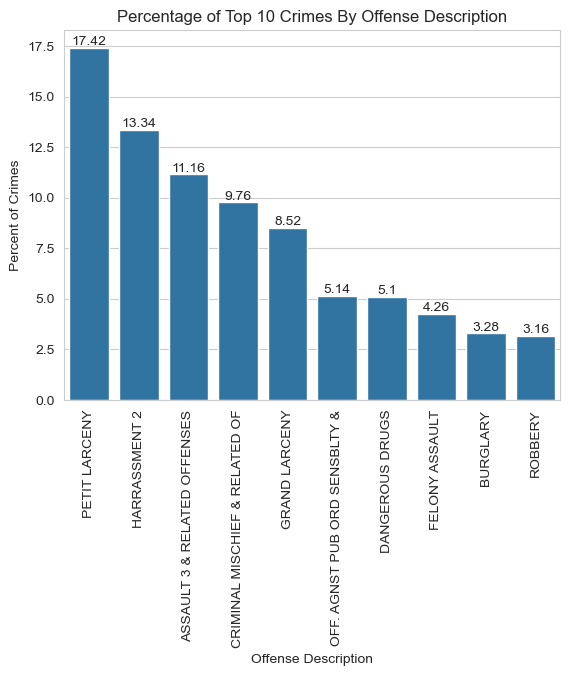

In [16]:
# Visualize crimes by offense description
ax = sns.countplot(data=data_sample, 
                   x='OFNS_DESC', 
                   stat='percent',
                  order=data_sample['OFNS_DESC'].value_counts(ascending=False).iloc[:10].index)
ax.set_xlabel('Offense Description')
plt.xticks(rotation=90)
ax.set_ylabel('Percent of Crimes')
ax.set_title('Percentage of Top 10 Crimes By Offense Description')
ax.bar_label(ax.containers[0]);

In [17]:
data.index

RangeIndex(start=0, stop=8914838, step=1)

In [18]:
data_sample.index

Index([7815550, 6965640, 8218283, 7264768, 5511302, 8040673, 3484297, 6155361,
       3932137, 8410991,
       ...
       7416630, 8735124, 2621961, 2190544, 8199912, 5070301, 2175324, 2937920,
       6044042, 8886354],
      dtype='int64', length=5000)

In [19]:
# Create and set datetime object
data_sample['CMPLNT_FR_DT'] = pd.to_datetime(data_sample['CMPLNT_FR_DT'], format='%m/%d/%Y')

In [20]:
# Set index as datetime
data_sample = data_sample.set_index(data_sample['CMPLNT_FR_DT'], drop=True).sort_index()
data_sample.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
1960-10-21,59824453H15716,1960-10-21,12:00:00,NaN,(null),NaN,03/20/2009,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO MAN NORTH,(null),65+,BLACK,M
1996-07-01,10154683,1996-07-01,15:00:00,05/01/2001,15:00:00,107.0,01/19/2006,104,RAPE,157.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),<18,AMERICAN INDIAN/ALASKAN NATIVE,F
1998-06-29,91552517,1998-06-29,00:01:00,09/09/1999,00:01:00,73.0,07/09/2013,109,GRAND LARCENY,422.0,...,U,NaN,40.669193,-73.909639,"(40.669193, -73.909639)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
1999-05-29,16858361,1999-05-29,09:00:00,NaN,(null),75.0,06/19/2006,112,THEFT-FRAUD,739.0,...,(null),NaN,40.685100,-73.877289,"(40.6851, -73.877289)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,M
2002-01-01,83321177,2002-01-01,12:00:00,NaN,(null),69.0,02/22/2012,233,SEX CRIMES,175.0,...,M,NaN,40.648614,-73.905257,"(40.6486135510607, -73.9052572032302)",PATROL BORO BKLYN SOUTH,(null),<18,BLACK,F


In [21]:
# Delete
data_sample.index

DatetimeIndex(['1960-10-21', '1996-07-01', '1998-06-29', '1999-05-29',
               '2002-01-01', '2002-01-01', '2002-07-17', '2004-01-01',
               '2004-01-01', '2005-01-17',
               ...
               '2023-12-26', '2023-12-26', '2023-12-26', '2023-12-27',
               '2023-12-27', '2023-12-28', '2023-12-28', '2023-12-29',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='CMPLNT_FR_DT', length=5000, freq=None)

In [22]:
# Delete
data_sample.index[0].day

21

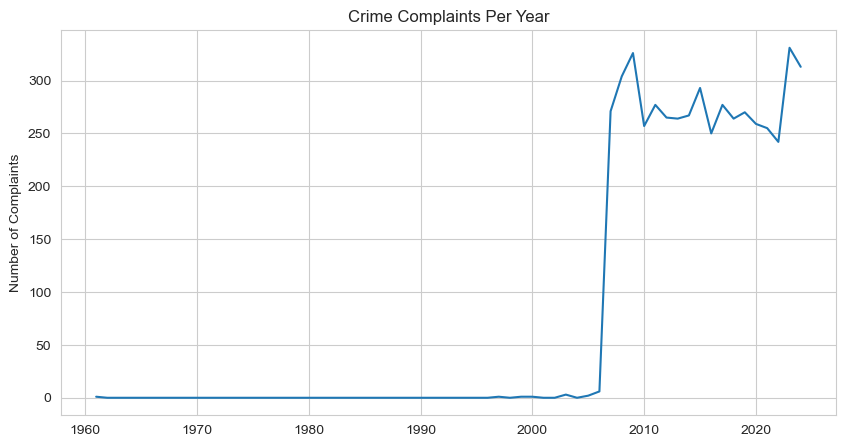

In [23]:
# Resample data to yearly and plot time series
fig, ax = plt.subplots(figsize=(10, 5))
data_sample_yearly = data_sample.resample('YE').count()['CMPLNT_FR_DT']
ax.plot(data_sample_yearly.index, data_sample_yearly.values)
ax.set_title('Crime Complaints Per Year')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above time plot

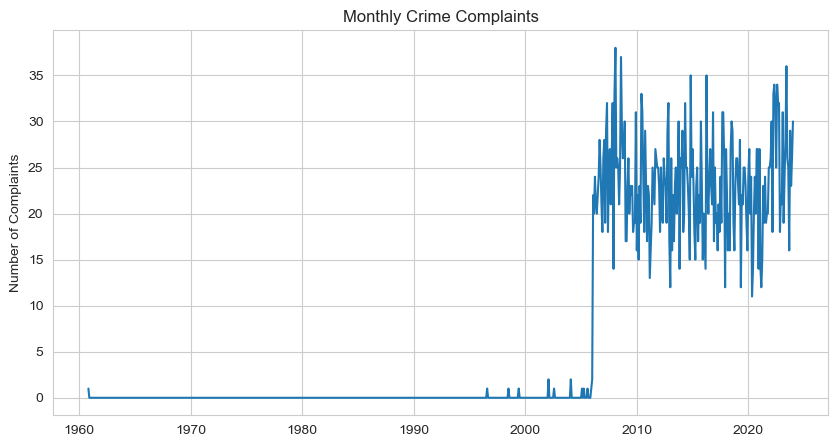

In [24]:
# Resample data to weekly and plot time series
fig, ax = plt.subplots(figsize=(10, 5))
data_sample_monthly = data_sample.resample('ME').count()['CMPLNT_FR_DT']
ax.plot(data_sample_monthly.index, data_sample_monthly.values)
ax.set_title('Monthly Crime Complaints')
ax.set_ylabel('Number of Complaints');

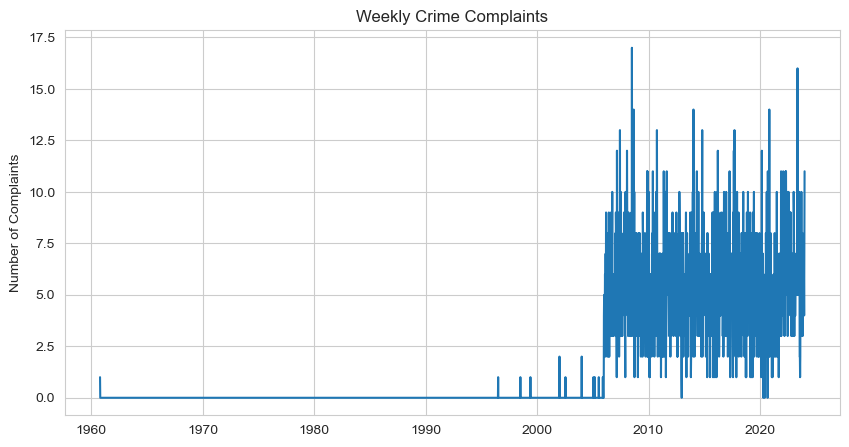

In [25]:
# Resample data to weekly and plot time series
fig, ax = plt.subplots(figsize=(10, 5))
data_sample_weekly = data_sample.resample('W').count()['CMPLNT_FR_DT']
ax.plot(data_sample_weekly.index, data_sample_weekly.values)
ax.set_title('Weekly Crime Complaints')
ax.set_ylabel('Number of Complaints');

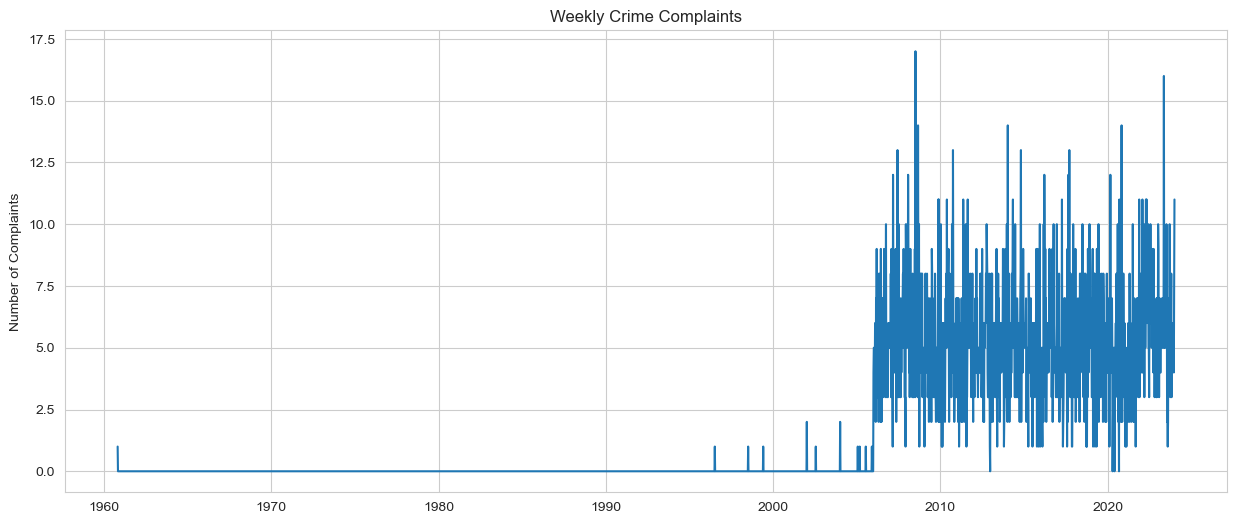

In [26]:
# Resample data to weekly and plot time series
fig, ax = plt.subplots(figsize=(15, 6))
data_sample_weekly = data_sample.resample('W').count()['CMPLNT_FR_DT']
ax.plot(data_sample_weekly.index, data_sample_weekly.values)
ax.set_title('Weekly Crime Complaints')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above time plot

In [27]:
# Create column to sort complaints by month
data_sample['Month'] = data_sample.index.month
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data_sample.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Month
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
1960-10-21,59824453H15716,1960-10-21,12:00:00,NaN,(null),NaN,03/20/2009,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,NaN,NaN,NaN,PATROL BORO MAN NORTH,(null),65+,BLACK,M,10
1996-07-01,10154683,1996-07-01,15:00:00,05/01/2001,15:00:00,107.0,01/19/2006,104,RAPE,157.0,...,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),<18,AMERICAN INDIAN/ALASKAN NATIVE,F,7
1998-06-29,91552517,1998-06-29,00:01:00,09/09/1999,00:01:00,73.0,07/09/2013,109,GRAND LARCENY,422.0,...,NaN,40.669193,-73.909639,"(40.669193, -73.909639)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F,6
1999-05-29,16858361,1999-05-29,09:00:00,NaN,(null),75.0,06/19/2006,112,THEFT-FRAUD,739.0,...,NaN,40.685100,-73.877289,"(40.6851, -73.877289)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,M,5
2002-01-01,83321177,2002-01-01,12:00:00,NaN,(null),69.0,02/22/2012,233,SEX CRIMES,175.0,...,NaN,40.648614,-73.905257,"(40.6486135510607, -73.9052572032302)",PATROL BORO BKLYN SOUTH,(null),<18,BLACK,F,1


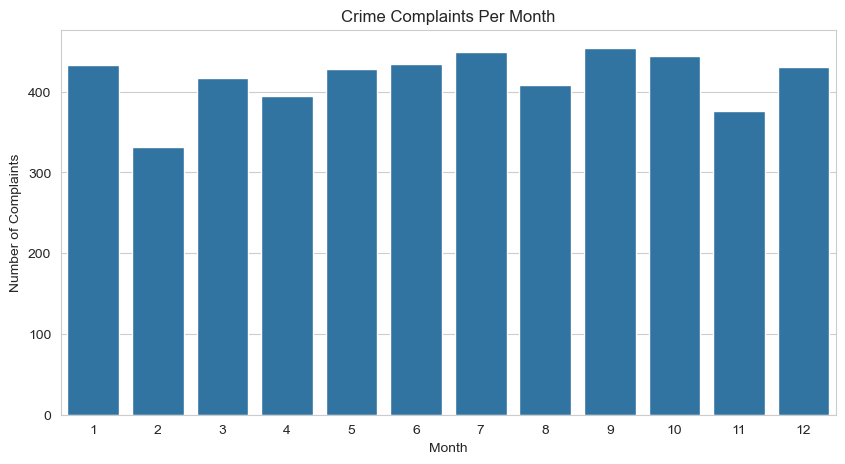

In [28]:
# Plot bar chart of number of complaints per month

x = data_sample['Month'].value_counts().index
y = data_sample['Month'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Month')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

In [29]:
data_sample.index[0]

Timestamp('1960-10-21 00:00:00')

In [30]:
data_sample.index[0].weekday

<bound method Timestamp.weekday of Timestamp('1960-10-21 00:00:00')>

In [31]:
# Create column to sort complaints by weekday
data_sample['Weekday'] = data_sample.index.weekday
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data_sample.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Month,Weekday
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
1960-10-21,59824453H15716,1960-10-21,12:00:00,NaN,(null),NaN,03/20/2009,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,NaN,NaN,PATROL BORO MAN NORTH,(null),65+,BLACK,M,10,4
1996-07-01,10154683,1996-07-01,15:00:00,05/01/2001,15:00:00,107.0,01/19/2006,104,RAPE,157.0,...,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),<18,AMERICAN INDIAN/ALASKAN NATIVE,F,7,0
1998-06-29,91552517,1998-06-29,00:01:00,09/09/1999,00:01:00,73.0,07/09/2013,109,GRAND LARCENY,422.0,...,40.669193,-73.909639,"(40.669193, -73.909639)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F,6,0
1999-05-29,16858361,1999-05-29,09:00:00,NaN,(null),75.0,06/19/2006,112,THEFT-FRAUD,739.0,...,40.685100,-73.877289,"(40.6851, -73.877289)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,M,5,5
2002-01-01,83321177,2002-01-01,12:00:00,NaN,(null),69.0,02/22/2012,233,SEX CRIMES,175.0,...,40.648614,-73.905257,"(40.6486135510607, -73.9052572032302)",PATROL BORO BKLYN SOUTH,(null),<18,BLACK,F,1,1


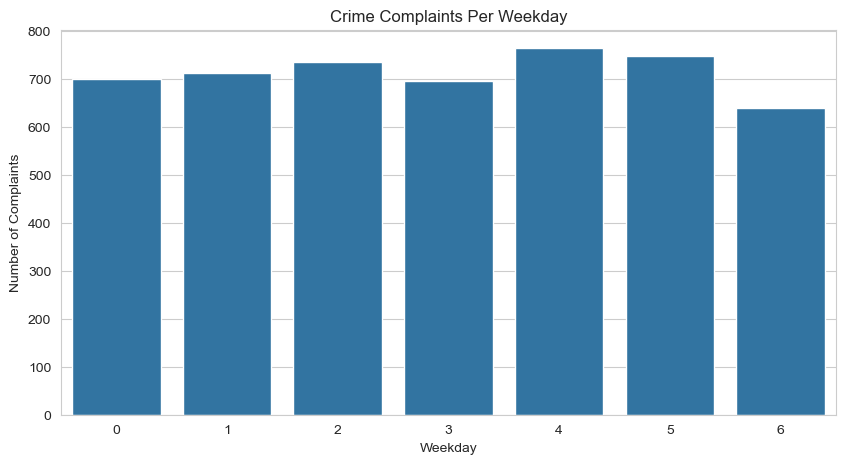

In [32]:
# Plot bar chart of number of complaints per weekday

x = data_sample['Weekday'].value_counts().index
y = data_sample['Weekday'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y, order=x.sort_values())
ax.set_title('Crime Complaints Per Weekday')
ax.set_ylabel('Number of Complaints');

In [33]:
# Create column to sort complaints by hour of occurence
data_sample['Hour'] = data_sample['CMPLNT_FR_TM']
data_sample['Hour'] = data_sample['Hour'].apply(lambda x: x[:2])
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data_sample.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Month,Weekday,Hour
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
1960-10-21,59824453H15716,1960-10-21,12:00:00,NaN,(null),NaN,03/20/2009,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,NaN,PATROL BORO MAN NORTH,(null),65+,BLACK,M,10,4,12
1996-07-01,10154683,1996-07-01,15:00:00,05/01/2001,15:00:00,107.0,01/19/2006,104,RAPE,157.0,...,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),<18,AMERICAN INDIAN/ALASKAN NATIVE,F,7,0,15
1998-06-29,91552517,1998-06-29,00:01:00,09/09/1999,00:01:00,73.0,07/09/2013,109,GRAND LARCENY,422.0,...,-73.909639,"(40.669193, -73.909639)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F,6,0,00
1999-05-29,16858361,1999-05-29,09:00:00,NaN,(null),75.0,06/19/2006,112,THEFT-FRAUD,739.0,...,-73.877289,"(40.6851, -73.877289)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,M,5,5,09
2002-01-01,83321177,2002-01-01,12:00:00,NaN,(null),69.0,02/22/2012,233,SEX CRIMES,175.0,...,-73.905257,"(40.6486135510607, -73.9052572032302)",PATROL BORO BKLYN SOUTH,(null),<18,BLACK,F,1,1,12


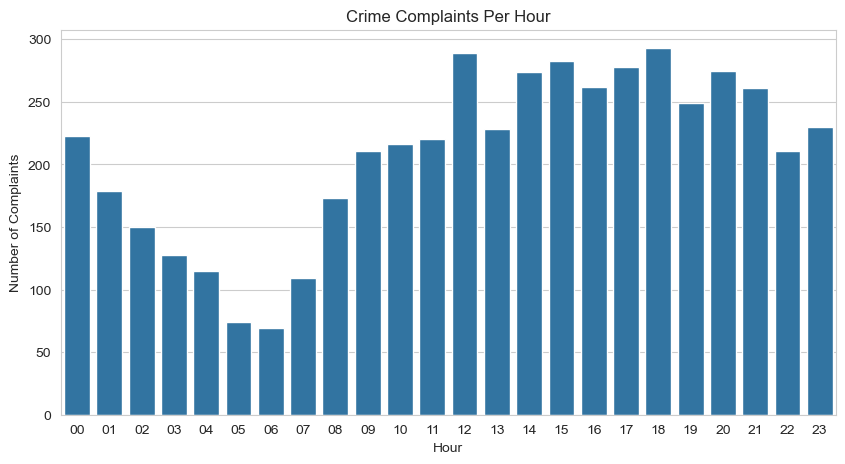

In [34]:
# Plot bar chart of number of complaints per hour

x = data_sample['Hour'].value_counts().index
y = data_sample['Hour'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y, order=x.sort_values())
ax.set_title('Crime Complaints Per Hour')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

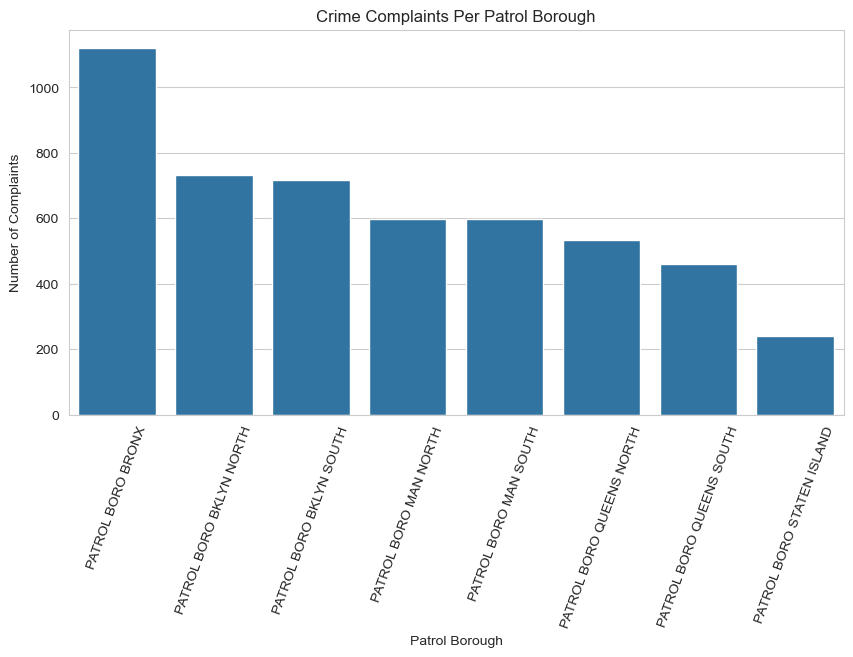

In [35]:
# Plot bar chart of number of complaints per patrol borough

x = data_sample['PATROL_BORO'].value_counts().index
y = data_sample['PATROL_BORO'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Patrol Borough')
plt.xticks(rotation=70)
ax.set_xlabel('Patrol Borough')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

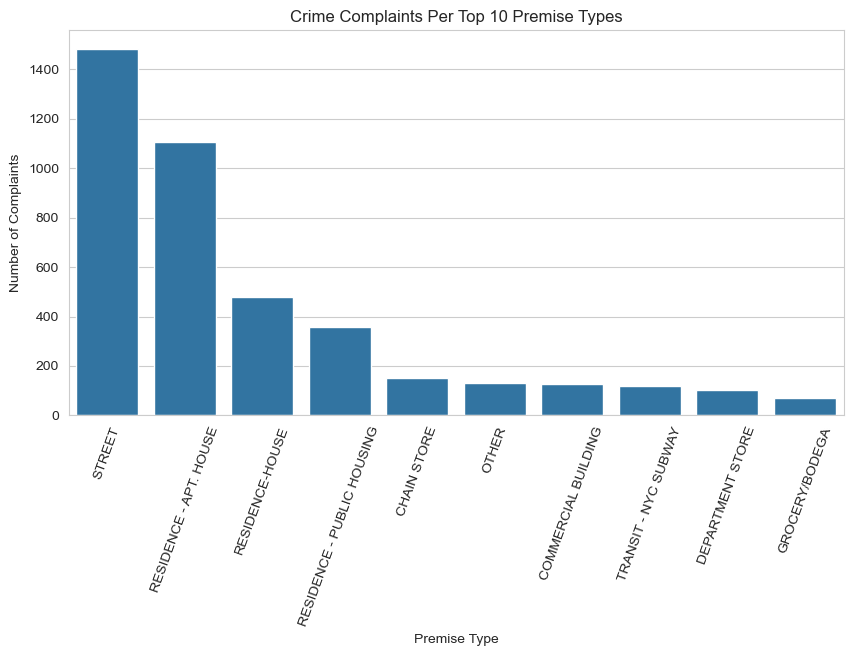

In [36]:
# Plot bar chart of number of complaints per premise type description

x = data_sample['PREM_TYP_DESC'].value_counts().index[:10]
y = data_sample['PREM_TYP_DESC'].value_counts().values[:10]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Top 10 Premise Types')
plt.xticks(rotation=70)
ax.set_xlabel('Premise Type')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

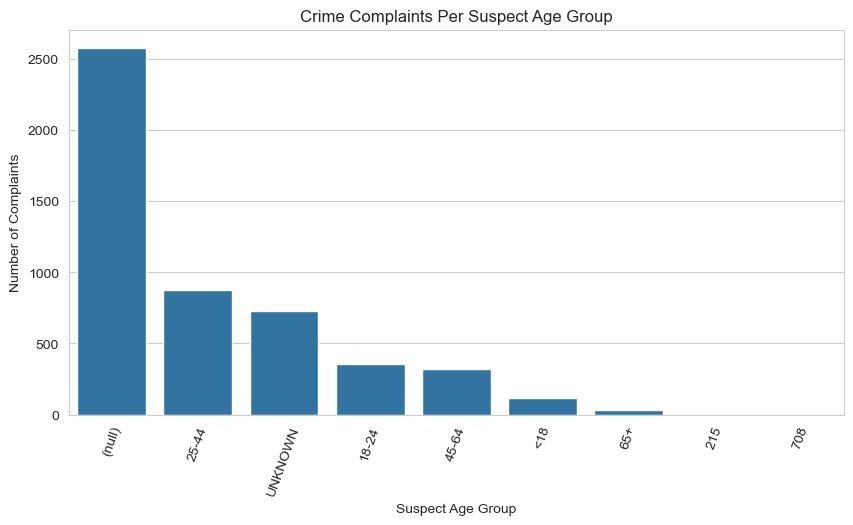

In [37]:
# Plot bar chart of number of complaints per suspect age group

x = data_sample['SUSP_AGE_GROUP'].value_counts().index
y = data_sample['SUSP_AGE_GROUP'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Suspect Age Group')
plt.xticks(rotation=70)
ax.set_xlabel('Suspect Age Group')
ax.set_ylabel('Number of Complaints');

In [38]:
data_sample['SUSP_AGE_GROUP'].value_counts()

SUSP_AGE_GROUP
(null)     2575
25-44       874
UNKNOWN     727
18-24       357
45-64       317
<18         119
65+          29
215           1
708           1
Name: count, dtype: int64

##TO DO
Add summary of above bar plot

NOT USEFUL

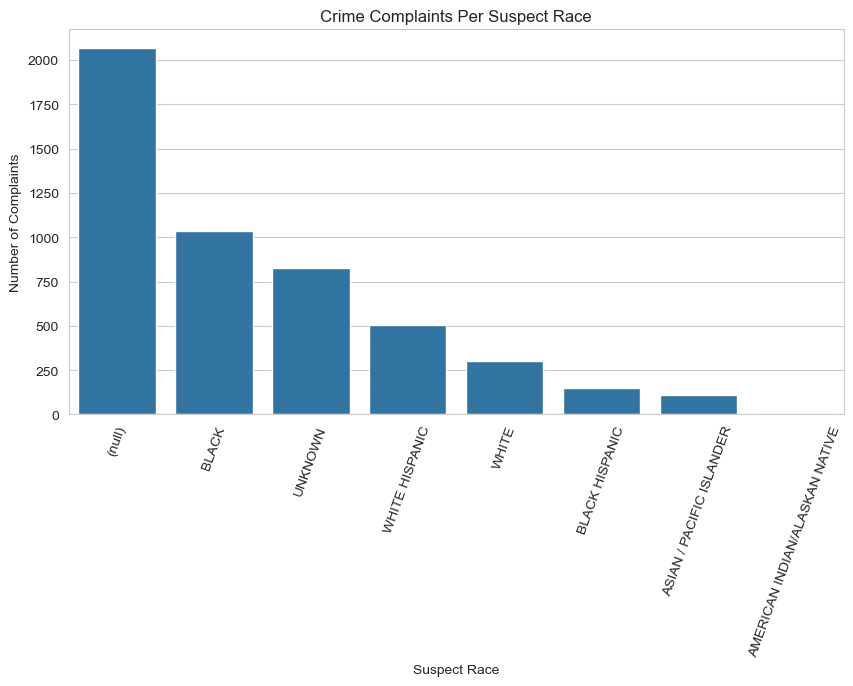

In [39]:
# Plot bar chart of number of complaints per suspect race

x = data_sample['SUSP_RACE'].value_counts().index
y = data_sample['SUSP_RACE'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Suspect Race')
plt.xticks(rotation=70)
ax.set_xlabel('Suspect Race')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

This would also have to be compared to the demographics of New Yorkers in all 5 boroughs

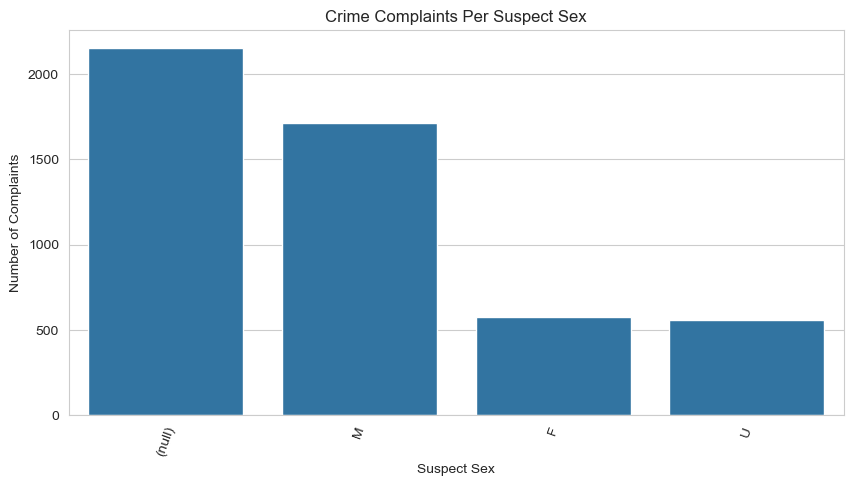

In [40]:
# Plot bar chart of number of complaints per suspect sex

x = data_sample['SUSP_SEX'].value_counts().index
y = data_sample['SUSP_SEX'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Suspect Sex')
plt.xticks(rotation=70)
ax.set_xlabel('Suspect Sex')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

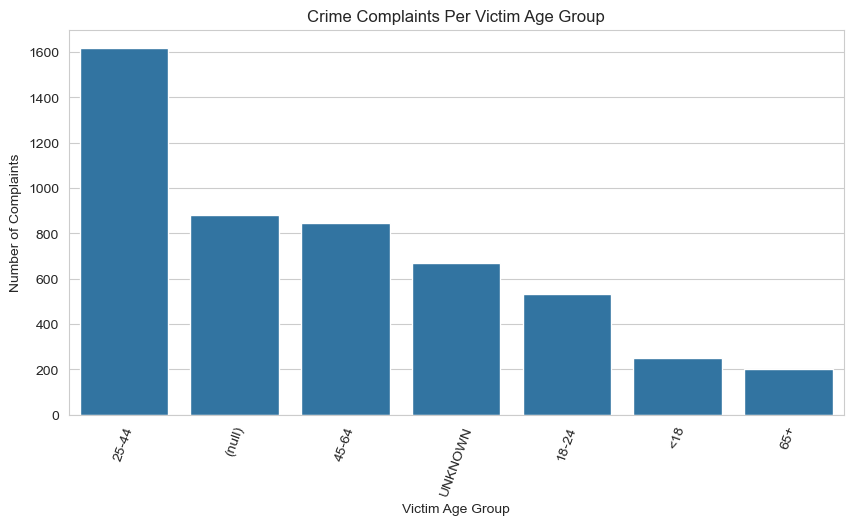

In [41]:
# Plot bar chart of number of complaints per victim age group

x = data_sample['VIC_AGE_GROUP'].value_counts().index
y = data_sample['VIC_AGE_GROUP'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Victim Age Group')
plt.xticks(rotation=70)
ax.set_xlabel('Victim Age Group')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

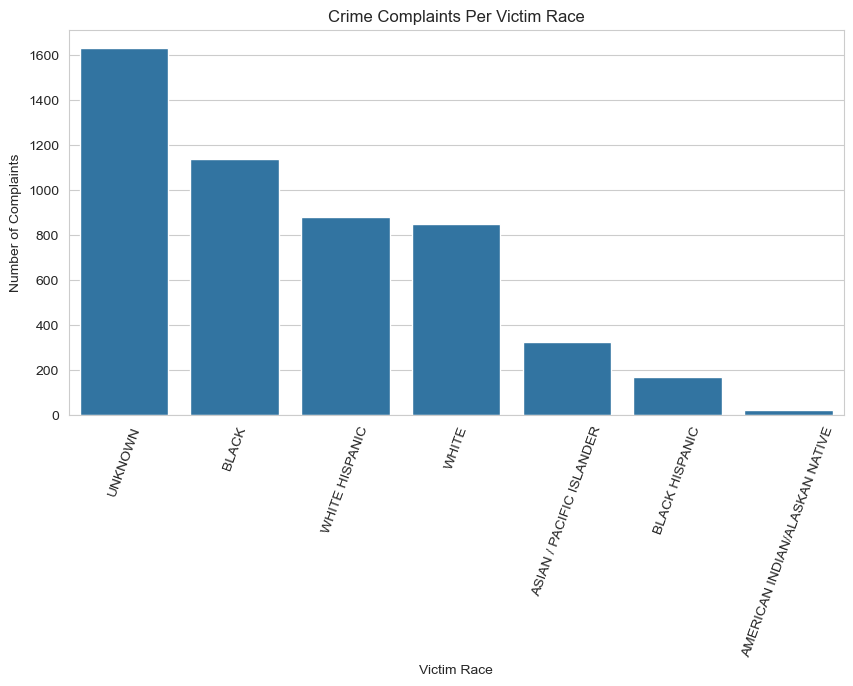

In [42]:
# Plot bar chart of number of complaints per victim race

x = data_sample['VIC_RACE'].value_counts().index
y = data_sample['VIC_RACE'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Victim Race')
plt.xticks(rotation=70)
ax.set_xlabel('Victim Race')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

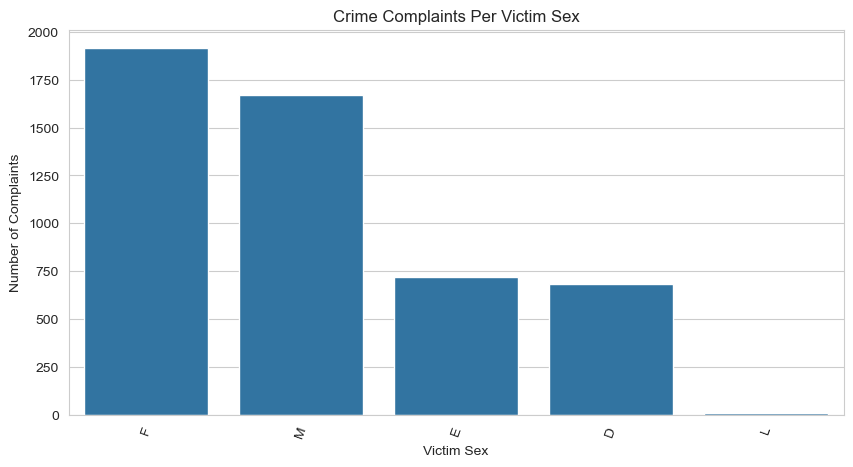

In [43]:
# Plot bar chart of number of complaints per victim sex

x = data_sample['VIC_SEX'].value_counts().index
y = data_sample['VIC_SEX'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Victim Sex')
plt.xticks(rotation=70)
ax.set_xlabel('Victim Sex')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

In [44]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 1960-10-21 to 2023-12-30
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CMPLNT_NUM         5000 non-null   object        
 1   CMPLNT_FR_DT       5000 non-null   datetime64[ns]
 2   CMPLNT_FR_TM       5000 non-null   object        
 3   CMPLNT_TO_DT       3948 non-null   object        
 4   CMPLNT_TO_TM       5000 non-null   object        
 5   ADDR_PCT_CD        4999 non-null   float64       
 6   RPT_DT             5000 non-null   object        
 7   KY_CD              5000 non-null   int64         
 8   OFNS_DESC          5000 non-null   object        
 9   PD_CD              4994 non-null   float64       
 10  PD_DESC            5000 non-null   object        
 11  CRM_ATPT_CPTD_CD   5000 non-null   object        
 12  LAW_CAT_CD         5000 non-null   object        
 13  BORO_NM            5000 non-null   object    

## Data Preparation

In [45]:
print(data_sample_weekly.head(15), data_sample_weekly.tail(15))

CMPLNT_FR_DT
1960-10-23    1
1960-10-30    0
1960-11-06    0
1960-11-13    0
1960-11-20    0
1960-11-27    0
1960-12-04    0
1960-12-11    0
1960-12-18    0
1960-12-25    0
1961-01-01    0
1961-01-08    0
1961-01-15    0
1961-01-22    0
1961-01-29    0
Freq: W-SUN, Name: CMPLNT_FR_DT, dtype: int64 CMPLNT_FR_DT
2023-09-24     7
2023-10-01     3
2023-10-08     5
2023-10-15     6
2023-10-22     8
2023-10-29     3
2023-11-05     6
2023-11-12     5
2023-11-19     5
2023-11-26     6
2023-12-03     6
2023-12-10     6
2023-12-17     4
2023-12-24     8
2023-12-31    11
Freq: W-SUN, Name: CMPLNT_FR_DT, dtype: int64


According to the graph and the list of the first 15 datapoints in `data_sample_weekly`, the beginning of the data is not reliable. There are many missing datapoints. The description of the data states that it begins in the year 2006, so I will remove all datapoints before that year.

In [46]:
# Remove any entries before year 2006
data_sample_weekly = data_sample_weekly[data_sample_weekly.index>'2006-01-01']

In [47]:
# Check if any weeks have 0 complaints
data_sample_weekly.value_counts()

CMPLNT_FR_DT
5     168
6     153
4     152
3     122
7      84
8      73
2      62
9      36
1      31
10     27
11     13
12      5
13      4
0       4
14      3
17      1
16      1
Name: count, dtype: int64

In [48]:
data_sample_weekly

CMPLNT_FR_DT
2006-01-08     5
2006-01-15     5
2006-01-22     4
2006-01-29     4
2006-02-05     6
              ..
2023-12-03     6
2023-12-10     6
2023-12-17     4
2023-12-24     8
2023-12-31    11
Freq: W-SUN, Name: CMPLNT_FR_DT, Length: 939, dtype: int64

In [49]:
# Look at which weeks have 0 complaints
data_sample_weekly[data_sample_weekly==0]

CMPLNT_FR_DT
2012-12-23    0
2020-04-19    0
2020-05-31    0
2020-09-06    0
Name: CMPLNT_FR_DT, dtype: int64

I wondered if it was possible for these 5 weeks to have 0 crime complaints. The answer is no due to a quick Google search. On the night of April 4th, 2010, [54 people were shot and 4 were arrested](https://nypost.com/2010/04/05/54-arrested-4-shot-in-times-square-riot/) in a riot in Times Square according to the NY Post. According to CNN, there were multiple crime incidents the week of August 16, 2020, with [20 victims as a result of 12 shooting incidents on [8/14/2020], and 23 victims as a result of 20 shooting incidents on [8/15/2020]](https://www.cnn.com/2020/08/16/us/nyc-chicago-gun-violence/index.html). When data is resampled weekly, the date listed is the end of the week.

This demonstrated that not all crime complaints are listed in this data, and 0 complaints does not necessarily mean there was no crime that week. There are gaps in the data that need to be addressed. 

## Feature Engineering

## Train Test Split (Edit title name)

In [50]:
# Find the index which allows us to split off 20% of the data
cutoff = round(data_sample_weekly.shape[0]*0.8)
cutoff

751

In [51]:
# Define train and test sets according to cutoff index above
train = data_sample_weekly[:cutoff]

test = data_sample_weekly[cutoff:]

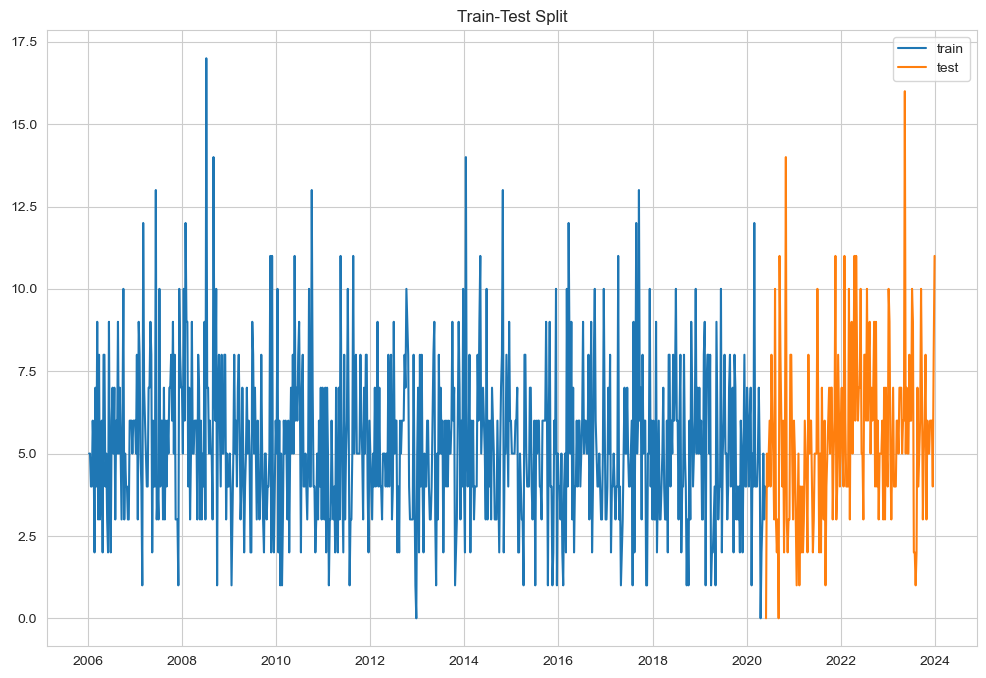

In [52]:
# Plot time series with cutoff highlighted
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [53]:
# Complete a train test split with TimeSeriesSplit
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(f'Train index: {train_ind}')
    print(f'Test  index: {val_ind}')

Train index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]
Test  index: [126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239

# Modeling

In [54]:
def display_df(dftest):
    '''
    Display the output from a Dickey-Fuller test in a more readable format
    '''
    
    
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    display(dfoutput)
    
    print(f"The p-value associated with the Dickey-Fuller statistical test is {dfoutput['p-value']},")
    if dfoutput['p-value'] < 0.05:
        print(" so we can safely assume that the differenced data is stationary.")
    else:
        print(" so we cannot reject the null hypothesis that the differenced data is \
    not stationary.")

## Baseline Model

In [55]:
# Create baseline model with shift operator
naive = train.shift(1)
naive

CMPLNT_FR_DT
2006-01-08    NaN
2006-01-15    5.0
2006-01-22    5.0
2006-01-29    4.0
2006-02-05    4.0
             ... 
2020-04-26    0.0
2020-05-03    2.0
2020-05-10    3.0
2020-05-17    5.0
2020-05-24    3.0
Freq: W-SUN, Name: CMPLNT_FR_DT, Length: 751, dtype: float64

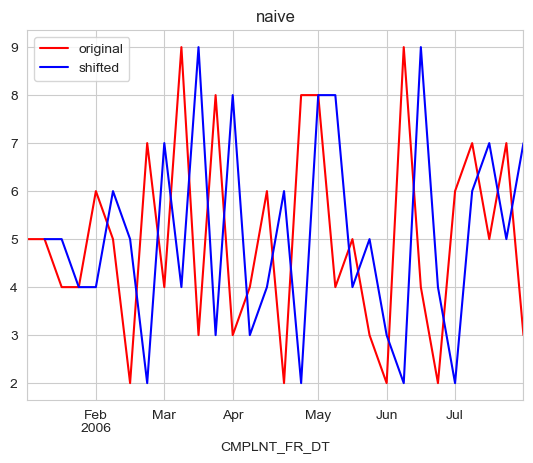

In [56]:
# Plot baseline model
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

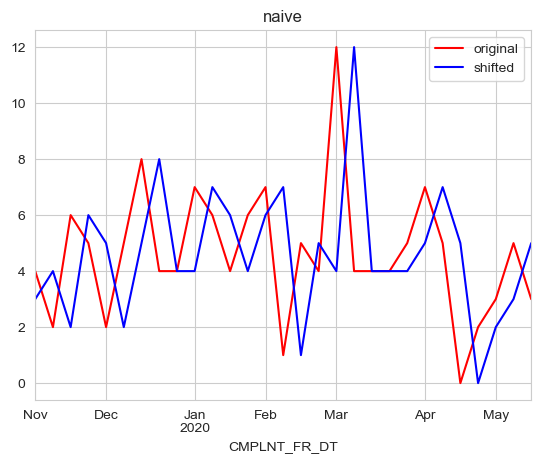

In [57]:
# Plot baseline model
fig, ax = plt.subplots()

train[-30:-1].plot(ax=ax, c='r', label='original')
naive[-30:-1].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [58]:
# Calculate RMSE for baseline model
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

3.4123305818750915

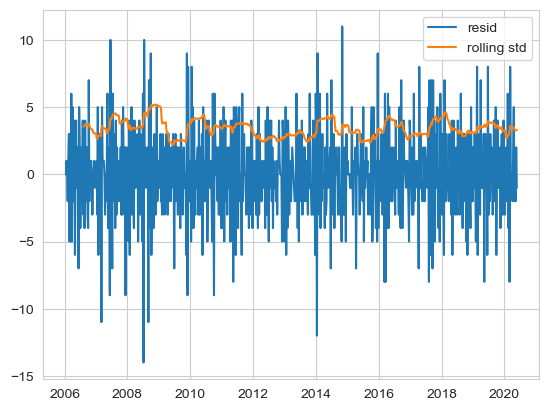

In [59]:
# 
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals, label='resid')
ax.plot(residuals.index, residuals.rolling(30).std(), label='rolling std')
ax.legend();

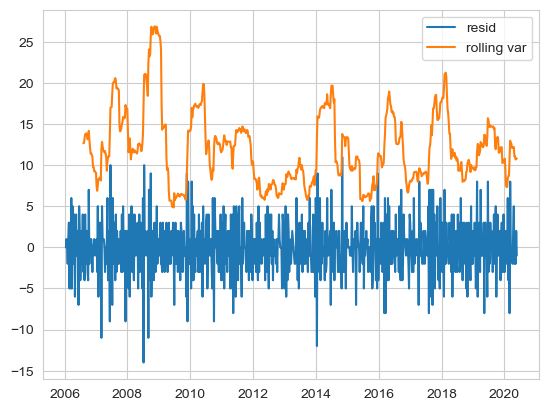

In [60]:
# 
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals, label='resid')
ax.plot(residuals.index, residuals.rolling(30).var(), label='rolling var')
ax.legend();

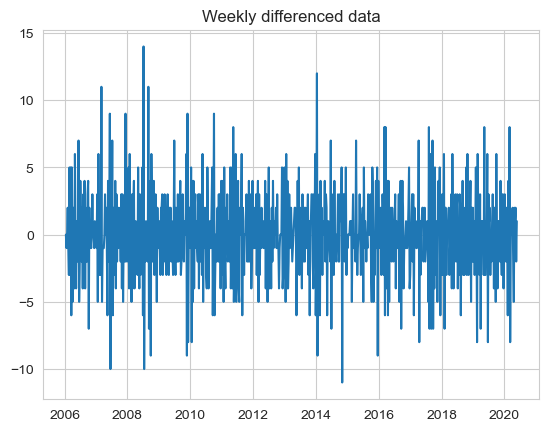

In [61]:
# Visualize differenced data
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

In [62]:
dftest = adfuller(test.diff()[1:])
display_df(dftest)

Test Statistic                -9.999656e+00
p-value                        1.899084e-17
#Lags Used                     5.000000e+00
Number of Observations Used    1.810000e+02
Critical Value (1%)           -3.467005e+00
Critical Value (5%)           -2.877644e+00
Critical Value (10%)          -2.575355e+00
dtype: float64

The p-value associated with the Dickey-Fuller statistical test is 1.8990836202208115e-17,
 so we can safely assume that the differenced data is stationary.


## Model Iterations

### Arima Model

In [63]:
# ar_1 model with differencing
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

CMPLNT_FR_DT
2006-01-08    0.000000
2006-01-15    4.999969
2006-01-22    5.000000
2006-01-29    4.526441
2006-02-05    4.000000
                ...   
2020-04-26    2.632207
2020-05-03    0.947117
2020-05-10    2.473559
2020-05-17    3.947117
2020-05-24    4.052883
Freq: W-SUN, Name: predicted_mean, Length: 751, dtype: float64

In [64]:
# Summary
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           CMPLNT_FR_DT   No. Observations:                  751
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1862.844
Date:                Thu, 16 Jan 2025   AIC                           3729.688
Time:                        22:59:33   BIC                           3738.928
Sample:                    01-08-2006   HQIC                          3733.248
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5264      0.030    -17.498      0.000      -0.585      -0.467
sigma2         8.4087      0.389     21.600      0.000       7.646       9.172
===================================================================================
Ljung-Box (L1) (Q):                  18.88   Jarque-Bera (JB):                26.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.38
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
# Random walk
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           CMPLNT_FR_DT   No. Observations:                  751
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1984.751
Date:                Thu, 16 Jan 2025   AIC                           3971.501
Time:                        22:59:34   BIC                           3976.121
Sample:                    01-08-2006   HQIC                          3973.281
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        11.6440      0.520     22.374      0.000      10.624      12.664
===================================================================================
Ljung-Box (L1) (Q):                 209.20   Jarque-Bera (JB):                15.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.09
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
# Baseline ARIMA model
baseline = ARIMA(train, order=(0,0,0)).fit()
bl_preds = baseline.predict(typ='levels')
bl_rmse = np.sqrt(mean_squared_error(train, bl_preds))

In [67]:
print(f'Baseline AIC: {baseline.aic}')
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Baseline AIC: 3452.7383859663832
Random Walk AIC: 3971.501069222233
AR(1, 1, 0) AIC: 3729.688057923968


In [68]:
y_hat_ar1 = ar_1.predict(typ='levels')
ar1_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [69]:
y_hat_rw = random_walk_model.predict(typ='levels')
rw_rmse = np.sqrt(mean_squared_error(train, y_hat_rw))

In [70]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')

Baseline RMSE:    2.4040598863329006
Random Walk RMSE: 3.4149354734191553
AR1 RMSE:         2.9035933782543295


The baseline ARIMA model has the best AIC and the best RMSE.

### Adding A Term

In [71]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

CMPLNT_FR_DT
2006-01-08    0.000000
2006-01-15    4.999969
2006-01-22    4.999987
2006-01-29    4.684095
2006-02-05    4.298814
                ...   
2020-04-26    4.018104
2020-05-03    2.125882
2020-05-10    1.718276
2020-05-17    3.332995
2020-05-24    3.770561
Freq: W-SUN, Name: predicted_mean, Length: 751, dtype: float64

In [72]:
print(baseline.aic)
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

3452.7383859663832
3971.501069222233
3729.688057923968
3661.378509799215


In [73]:
y_hat_ar1 = ar_2.predict(typ='levels')
ar2_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [74]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')
print(f'AR2 RMSE:         {ar2_rmse}')

Baseline RMSE:    2.4040598863329006
Random Walk RMSE: 3.4149354734191553
AR1 RMSE:         2.9035933782543295
AR2 RMSE:         2.7708478164805546


### Moving Average Model

In [75]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

CMPLNT_FR_DT
2006-01-08    5.243679
2006-01-15    5.245058
2006-01-22    5.245066
2006-01-29    5.250724
2006-02-05    5.250756
                ...   
2020-04-26    5.273357
2020-05-03    5.262201
2020-05-10    5.256480
2020-05-17    5.245131
2020-05-24    5.256383
Freq: W-SUN, Name: predicted_mean, Length: 751, dtype: float64

In [76]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           CMPLNT_FR_DT   No. Observations:                  751
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1724.356
Date:                Thu, 16 Jan 2025   AIC                           3454.712
Time:                        22:59:34   BIC                           3468.576
Sample:                    01-08-2006   HQIC                          3460.054
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2437      0.096     54.705      0.000       5.056       5.432
ma.L1         -0.0057      0.038     -0.149      0.881      -0.080       0.069
sigma2         5.7793      0.268     21.542      0.000       5.253       6.305
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                99.83
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.72
Prob(H) (two-sided):                  0.51   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()
print(baseline.aic)
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

3452.7383859663832
3971.501069222233
3729.688057923968
3661.378509799215
3454.4016103585473


In [78]:
y_hat_ar1 = ma_1.predict(typ='levels')
ma1_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [79]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')
print(f'AR2 RMSE:         {ar2_rmse}')
print(f'MA1 RMSE:         {ma1_rmse}')

Baseline RMSE:    2.4040598863329006
Random Walk RMSE: 3.4149354734191553
AR1 RMSE:         2.9035933782543295
AR2 RMSE:         2.7708478164805546
MA1 RMSE:         2.4169111748239467


In [80]:
# MA 2 lag past 2 terms
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

CMPLNT_FR_DT
2006-01-08    0.000000
2006-01-15    4.999971
2006-01-22    4.999985
2006-01-29    4.673579
2006-02-05    4.504479
                ...   
2020-04-26    5.166065
2020-05-03    5.129619
2020-05-10    5.107771
2020-05-17    5.089119
2020-05-24    5.094398
Freq: W-SUN, Name: predicted_mean, Length: 751, dtype: float64

In [81]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

3971.501069222233
3729.688057923968
3661.378509799215
3454.4016103585473
3456.3366465266818


In [82]:
y_hat_ar1 = ma_2.predict(typ='levels')
ma2_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [83]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')
print(f'AR2 RMSE:         {ar2_rmse}')
print(f'MA1 RMSE:         {ma1_rmse}')
print(f'MA2 RMSE:         {ma2_rmse}')

Baseline RMSE:    2.4040598863329006
Random Walk RMSE: 3.4149354734191553
AR1 RMSE:         2.9035933782543295
AR2 RMSE:         2.7708478164805546
MA1 RMSE:         2.4169111748239467
MA2 RMSE:         2.4167627483934364


### ARMA

In [84]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [85]:
print(baseline.aic)
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

3452.7383859663832
3971.501069222233
3729.688057923968
3661.378509799215
3454.4016103585473
3456.3366465266818
3458.632999910894


In [86]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [87]:
print(find_rmse(baseline))
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

2.4040598863329006
3.4149354734191553
2.9035933782543295
2.7708478164805546
2.4169111748239467
2.4167627483934364
2.414090226270299


### Test data

In [88]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [89]:
print(find_rmse_test(baseline))
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))

2.5713145527788313
2.9902323257068386
3.182380051566137
3.0970133421184003
2.5980445223183337
2.5985350977923383
2.5956101118671207


/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: Futur

## Final Model

# Conclusion

## Limitations

## Next Steps